In [1]:
import os
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE']='false'

import jax

from jax import random, jit, vmap, grad
from jax import numpy as jnp
from jax.lax import cond

import astropy
import numpy as np
import healpy as hp

import h5py
import astropy.units as u

from astropy.cosmology import Planck15, FlatLambdaCDM, z_at_value
import astropy.constants as constants
from jax.scipy.special import logsumexp
from scipy.interpolate import interp1d
from scipy.stats import gaussian_kde
from tqdm import tqdm

import matplotlib
%matplotlib inline

import matplotlib.pyplot as plt
matplotlib.rcParams['font.family'] = 'Times New Roman'
matplotlib.rcParams['font.sans-serif'] = ['Bitstream Vera Sans']
matplotlib.rcParams['text.usetex'] = False
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['figure.figsize'] = (16.0, 10.0)
matplotlib.rcParams['axes.unicode_minus'] = False

import seaborn as sns
sns.set_context('talk')
sns.set_style('ticks')
sns.set_palette('colorblind')
c=sns.color_palette('colorblind')

jax.config.update("jax_enable_x64", True)
jax.config.update('jax_default_matmul_precision', 'highest')


In [2]:
import h5py

filename = '../../../../gws-agn/data/mocks_glass/mock_seed42_ratioNgalNagn1_bgal1.0_bagn1.0/lognormal_pixelated_nside_256_galaxies.h5'

nside = 256

#biased 0.05, 0.01, 0.005 [0.001 or better unbiased]
with h5py.File(filename, 'r') as f:
    zgals = jnp.asarray(f['zgals'])
    dzgals = 0.0001*(1+zgals)
    wgals = jnp.ones(zgals.shape)
    ngals = jnp.asarray(f['ngals'])
    
filename = '../../../../gws-agn/data/mocks_glass/mock_seed42_ratioNgalNagn1_bgal1.0_bagn1.0/lognormal_pixelated_nside_256_agn.h5'

with h5py.File(filename, 'r') as f:
    zagns = jnp.asarray(f['zagn'])
    dzagns = 0.0001*(1+zagns)
    wagns = jnp.ones(zagns.shape)
    nagns = jnp.asarray(f['nagn'])

print(ngals.sum(),nagns.sum())
    

2025-10-31 00:49:29.643584: W external/xla/xla/service/gpu/nvptx_compiler.cc:930] The NVIDIA driver's CUDA version is 12.3 which is older than the PTX compiler version 12.6.77. Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


1176983 1177354


In [3]:
from jaxinterp2d import interp2d, CartesianGrid

zMax_1 = 0.5
zMax_2 = 5

H0Planck = Planck15.H0.value
Om0Planck = Planck15.Om0

cosmo = FlatLambdaCDM(H0=H0Planck,Om0=Planck15.Om0)
speed_of_light = constants.c.to('km/s').value

zgrid_1 = np.expm1(np.linspace(np.log(1), np.log(zMax_1+1), 5000))
zgrid_2 = np.expm1(np.linspace(np.log(zMax_1+1), np.log(zMax_2+1), 1000))
zgrid = np.concatenate([zgrid_1,zgrid_2])

rs = []
Om0grid = jnp.linspace(Om0Planck-0.1,Om0Planck+0.1,100)
for Om0 in tqdm(Om0grid):
    cosmo = FlatLambdaCDM(H0=H0Planck,Om0=Om0)
    rs.append(cosmo.comoving_distance(zgrid).to(u.Mpc).value)

zgrid = jnp.array(zgrid)
rs = jnp.asarray(rs)
rs = rs.reshape(len(Om0grid),len(zgrid))

@jit
def E(z,Om0=Om0Planck):
    return jnp.sqrt(Om0*(1+z)**3 + (1.0-Om0))

@jit
def r_of_z(z,H0,Om0=Om0Planck):
    return interp2d(Om0,z,Om0grid,zgrid,rs)*(H0Planck/H0)

@jit
def dL_of_z(z,H0,Om0=Om0Planck):
    return (1+z)*r_of_z(z,H0,Om0)

@jit
def z_of_dL(dL,H0,Om0=Om0Planck):
    return jnp.interp(dL,dL_of_z(zgrid,H0,Om0),zgrid)

@jit
def dV_of_z(z,H0,Om0=Om0Planck):
    return speed_of_light*r_of_z(z,H0,Om0)**2/(H0*E(z,Om0))

@jit
def ddL_of_z(z,dL,H0,Om0=Om0Planck):
    return dL/(1+z) + speed_of_light*(1+z)/(H0*E(z,Om0))

100%|██████████| 100/100 [00:00<00:00, 119.76it/s]


In [4]:
f_true = 0.5
lam_true = 0.5

filename = '../../../../gws-agn/data/mocks_glass/mock_seed42_ratioNgalNagn1_bgal1.0_bagn1.0/gwsamples_fagn'+str(f_true)+'_lambdaagn'+str(lam_true)+'_N1000_seed1042_pos_only.h5'

with h5py.File(filename, 'r') as inp:
        nsamps = inp.attrs['nsamp']
        nEvents_ = inp.attrs['nobs']
        ra = jnp.array(inp['ra'])
        dec = jnp.array(inp['dec'])
        dL = jnp.array((jnp.array(inp['dL'])*u.Mpc).value)

nsamp = 10000
nEvents = 1000
ra = ra.reshape(nEvents_,nsamps)[0:nEvents,0:nsamp]
dec = dec.reshape(nEvents_,nsamps)[0:nEvents,0:nsamp]
dL = dL.reshape(nEvents_,nsamps)[0:nEvents,0:nsamp]
print(ra.shape)
ra = ra[0:nEvents].flatten()
dec = dec[0:nEvents].flatten()
dL = dL[0:nEvents].flatten()

p_pe = jnp.ones(len(dL))

print(nEvents,nsamp)
print(z_of_dL(dL,140,Om0grid[-1]).max())

(1000, 10000)
1000 10000
3.1298544357561635


In [5]:
import healpy as hp

npix = hp.pixelfunc.nside2npix(nside)
apix = hp.pixelfunc.nside2pixarea(nside)

print(npix)
samples_ind = hp.pixelfunc.ang2pix(nside,np.pi/2-dec,ra)

786432


In [6]:
@jit
def dV_of_z_normed(z,Om0,gamma):
    dV = dV_of_z(zgrid,H0Planck,Om0)*(1+zgrid)**(gamma-1)
    prob = dV/jnp.trapezoid(dV,zgrid)
    return jnp.interp(z,zgrid,prob)


In [7]:
from jax.scipy.stats import norm

@jit
def logdiffexp(x, y):
    return x + jnp.log1p(jnp.exp(y-x))

In [33]:
from jaxinterp2d import interp2d

@jit
def logpcatalog_gals(z, pix, Om0, gamma):
    zs = zgals[pix] 
    ddzs = dzgals[pix]
    wts = wgals[pix]*(1+zs)**(gamma)
    ngals = jnp.sum(zs != 100)
    wts = wts/jnp.sum(wts)
    return logsumexp(jnp.log(wts) + norm.logpdf(z,zs,ddzs)), ngals

logpcatalog_gals_vmap = jit(vmap(logpcatalog_gals, in_axes=(0,0,None,None), out_axes=0))

def logpcatalog_agns(z, pix, Om0, gamma):
    zs = zagns[pix] 
    ddzs = dzagns[pix]
    wts = wagns[pix]*(1+zs)**(gamma)
    nagns = jnp.sum(zs != 100)
    wts = wts/jnp.sum(wts)
    return logsumexp(jnp.log(wts) + norm.logpdf(z,zs,ddzs)), nagns

logpcatalog_agns_vmap = jit(vmap(logpcatalog_agns, in_axes=(0,0,None,None), out_axes=0))

import jax.numpy as jnp
from jax.scipy.special import logsumexp

def logPriorUniverse(z, pix, f, lam, Om0, gamma_agn, gamma_gal, gamma_agn_disk):
    # Get log-prob catalogs and counts
    logpcat_agns, nagns = logpcatalog_agns_vmap(z, pix, Om0, gamma_agn)
    logpcat_gals, ngals = logpcatalog_gals_vmap(z, pix, Om0, gamma_gal)
    logpcat_agns_disk, nagns_disk = logpcatalog_agns_vmap(z, pix, Om0, gamma_agn_disk)


    # Non-disk mix count (per pixel)
    A = lam * nagns + (1.0 - lam) * ngals
    # Disk (AGN) branch: proportional to nagns
    log_term1 = jnp.log(f) + jnp.log(nagns) + logpcat_agns
    # Non-disk branch: proportional to lam*nagns and (1-lam)*ngals, then normalized by A
    log_inner1 = jnp.log(lam)       + jnp.log(nagns) + logpcat_agns
    log_inner2 = jnp.log(1.0 - lam) + jnp.log(ngals) + logpcat_gals
    log_inner  = jnp.logaddexp(log_inner1, log_inner2)
    log_term2  = jnp.log(1.0 - f) - jnp.log(A) + log_inner
    # Global per-pixel normalizer across branches
    log_norm = jnp.log(f * nagns + (1.0 - f) * A)
    # Final log-prob per sample
    log_prob = jnp.logaddexp(log_term1, log_term2) - log_norm
    return log_prob



In [34]:
seed = np.random.randint(1000)
key = jax.random.PRNGKey(1000)

Om0 = Om0Planck
def darksiren_log_likelihood(H0,f,lam,gamma_agn,gamma_gal,gamma_agn_disk):
    z = z_of_dL(dL, H0, Om0)

    log_weights = - jnp.log(ddL_of_z(z,dL,H0,Om0)) - jnp.log(p_pe) + logPriorUniverse(z,samples_ind,f,lam,Om0,gamma_agn,gamma_gal,gamma_agn_disk)

    log_weights = log_weights.reshape((nEvents,nsamp))
    ll = jnp.sum(-jnp.log(nsamp) + logsumexp(log_weights,axis=-1))
    
    return ll


In [35]:
darksiren_log_likelihood(H0=70,f=1,lam=0,gamma_agn=0,gamma_gal=0,gamma_agn_disk=0)

Array(nan, dtype=float64)

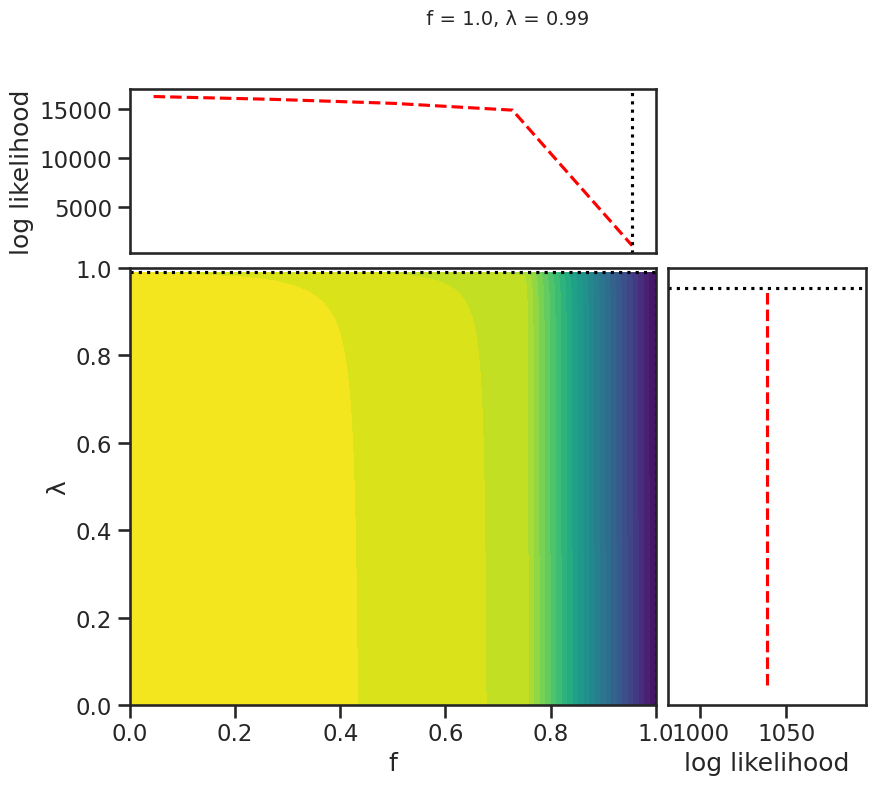

In [156]:
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

H0Planck = 67.4

# Define grids
fgrid = jnp.linspace(0, 1, 5)
lamgrid = jnp.linspace(0, 1, 100)

# Compute likelihood surface
LL = np.zeros((len(fgrid), len(lamgrid)))
for i, f in enumerate(fgrid):
    for j, lam in enumerate(lamgrid):
        LL[i, j] = darksiren_log_likelihood(H0=H0Planck, f=f, lam=lam)

fgrid_np = np.array(fgrid)
lamgrid_np = np.array(lamgrid)
F, LAM = np.meshgrid(fgrid_np, lamgrid_np, indexing="ij")

# # Marginalized likelihoods
# LL_marg_f = np.trapz(LL, x=lamgrid_np, axis=1)
# LL_marg_lam = np.trapz(LL, x=fgrid_np, axis=0)

# Fixed slices
fixed_lam = lam_true
fixed_f = f_true
j_fixed_lam = np.argmin(np.abs(lamgrid_np - fixed_lam))
i_fixed_f = np.argmin(np.abs(fgrid_np - fixed_f))
LL_fixed_lam = LL[:, j_fixed_lam]
LL_fixed_f = LL[i_fixed_f, :]

# Create figure with GridSpec
fig = plt.figure(figsize=(10, 8))
gs = GridSpec(2, 3, width_ratios=[4, 1.5, 0.2], height_ratios=[1.5, 4], hspace=0.05, wspace=0.05)

# Title
fig.suptitle(f" f = {f_true}, λ = {fixed_lam}", fontsize=14)

# Top panel
ax_top = fig.add_subplot(gs[0, 0])
#ax_top.plot(fgrid_np, LL_marg_f, label="Marginalized over λ", color="blue")
ax_top.plot(fgrid_np, LL_fixed_lam, label=f"Slice at λ = {fixed_lam}", color="red", linestyle="--")
ax_top.axvline(f_true, color="black", linestyle=":", label=f"True f = {f_true}")
ax_top.set_xticks([])
#ax_top.legend()
ax_top.set_ylabel("log likelihood")

# Right panel
ax_right = fig.add_subplot(gs[1, 1])
#ax_right.plot(LL_marg_lam, lamgrid_np, label="Marginalized over f", color="blue")
ax_right.plot(LL_fixed_f, lamgrid_np, label=f"Slice at f = {fixed_f}", color="red", linestyle="--")
ax_right.axhline(lam_true, color="black", linestyle=":", label=f"True λ = {lam_true}")
ax_right.set_yticks([])
#ax_right.legend()
ax_right.set_xlabel("log likelihood")

# Main contour plot
ax_main = fig.add_subplot(gs[1, 0])
cs = ax_main.contourf(F, LAM, LL, levels=30, cmap="viridis")
ax_main.axvline(f_true, color="black", linestyle=":")
ax_main.axhline(lam_true, color="black", linestyle=":")
ax_main.set_xlabel("f")
ax_main.set_ylabel("λ")

# # External colorbar (far right)
# cax = fig.add_subplot(gs[:, 2])
# fig.colorbar(cs, cax=cax, label="log likelihood")
plt.savefig(f"logl_fagn{f_true}_lam{fixed_lam}.pdf")
plt.show()


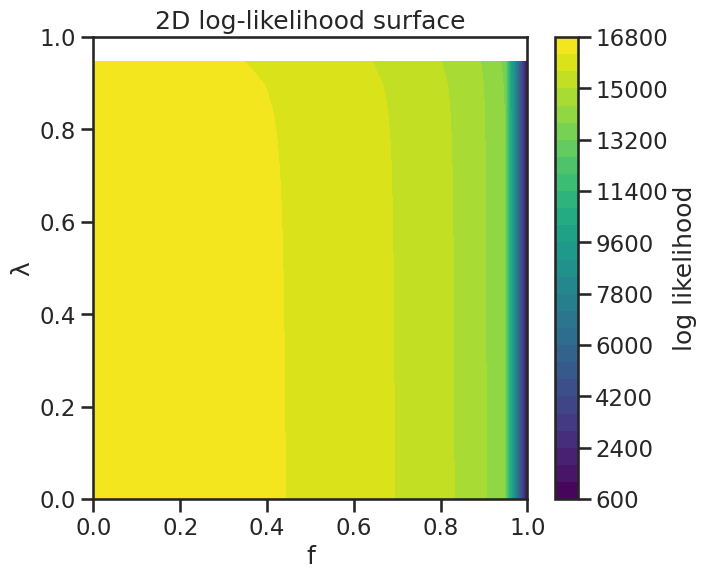

In [121]:
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt

# Define grids
fgrid = jnp.linspace(0, 1, 20)
lamgrid = jnp.linspace(0, 1, 20)  # adjust range as needed

# Allocate array for log-likelihoods
LL = np.zeros((len(fgrid), len(lamgrid)))

# Fill the grid
for i, f in enumerate(fgrid):
    for j, lam in enumerate(lamgrid):
        LL[i, j] = darksiren_log_likelihood(H0=H0Planck, f=f, lam=lam)

# Convert to numpy for plotting
F, LAM = np.meshgrid(np.array(fgrid), np.array(lamgrid), indexing="ij")

# Plot contours (potato-like shape)
plt.figure(figsize=(7,6))
cs = plt.contourf(F, LAM, LL, levels=30, cmap="viridis")
plt.colorbar(cs, label="log likelihood")
plt.xlabel("f")
plt.ylabel("λ")
plt.title("2D log-likelihood surface")
plt.show()


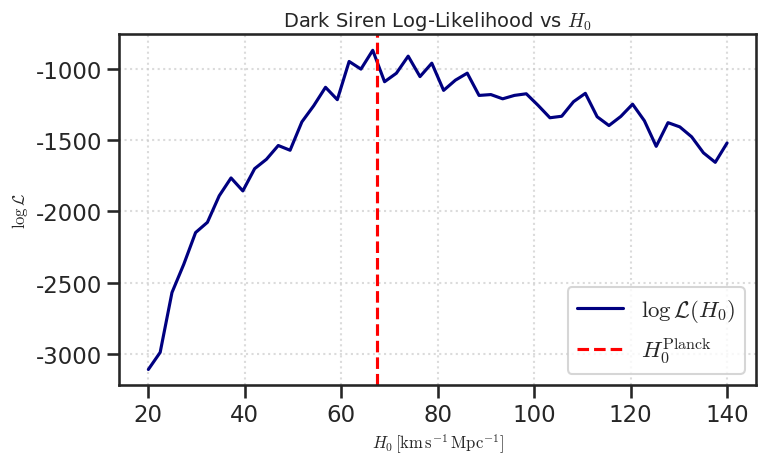

In [101]:
h0grid = jnp.linspace(20, 140, 50)

lls = []
for h0 in h0grid:
    lls.append(darksiren_log_likelihood(H0=h0, f=1.0, lam=0.999))

lls = np.array(lls)

plt.figure(figsize=(8,5))
plt.plot(h0grid, lls, label=r'$\log \mathcal{L}(H_0)$', color='navy')
plt.axvline(H0Planck, color='red', linestyle='--', label=r'$H_0^{\rm Planck}$')

plt.xlabel(r'$H_0 \, [\mathrm{km \, s^{-1} \, Mpc^{-1}}]$', fontsize=12)
plt.ylabel(r'$\log \mathcal{L}$', fontsize=12)
plt.title("Dark Siren Log-Likelihood vs $H_0$", fontsize=14)
plt.legend()
plt.grid(True, linestyle=':', alpha=0.7)

plt.tight_layout()
plt.show()


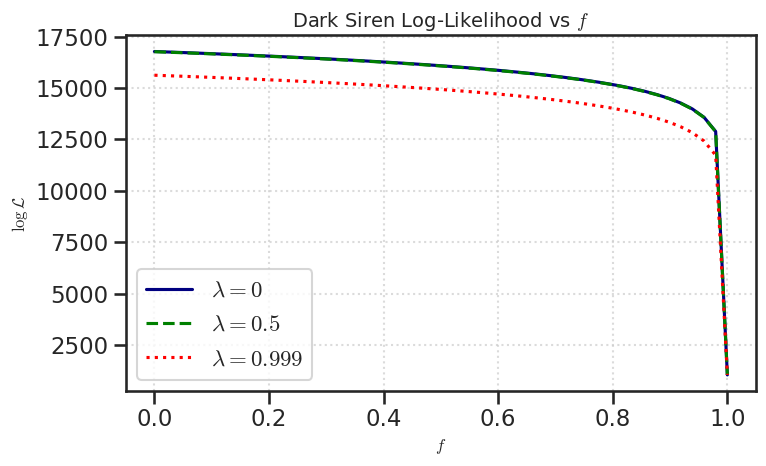

In [26]:
# f grid
fgrid = jnp.linspace(0, 1, 50)

# Compute log-likelihoods for each lambda
lls_0 = [darksiren_log_likelihood(H0=H0Planck, f=f, lam=0.0) for f in fgrid]
lls_05 = [darksiren_log_likelihood(H0=H0Planck, f=f, lam=0.5) for f in fgrid]
lls_0999 = [darksiren_log_likelihood(H0=H0Planck, f=f, lam=0.999) for f in fgrid]

# Convert to numpy arrays
lls_0 = np.array(lls_0)
lls_05 = np.array(lls_05)
lls_0999 = np.array(lls_0999)

# Plotting
plt.figure(figsize=(8,5))
plt.plot(fgrid, lls_0, label=r'$\lambda=0$', color='navy', linestyle='-')
plt.plot(fgrid, lls_05, label=r'$\lambda=0.5$', color='green', linestyle='--')
plt.plot(fgrid, lls_0999, label=r'$\lambda=0.999$', color='red', linestyle=':')

plt.xlabel(r'$f$', fontsize=12)
plt.ylabel(r'$\log \mathcal{L}$', fontsize=12)
plt.title(r"Dark Siren Log-Likelihood vs $f$", fontsize=14)
plt.legend()
plt.grid(True, linestyle=':', alpha=0.7)
plt.tight_layout()
plt.show()


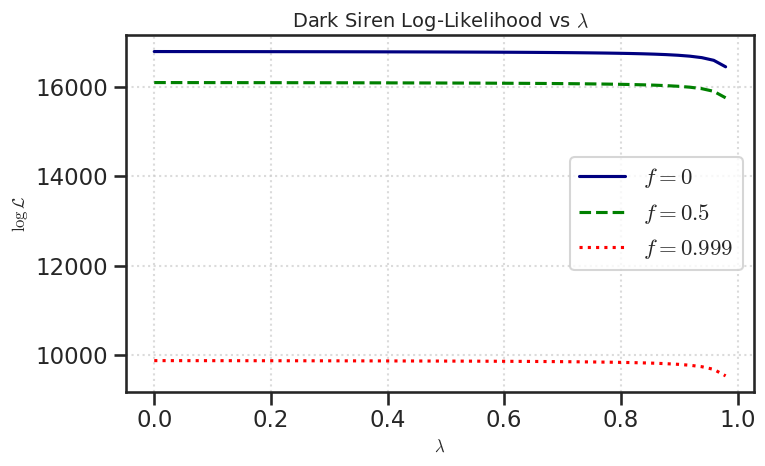

In [27]:
# λ grid
lamgrid = jnp.linspace(0, 1, 50)

# Compute log-likelihoods for each fixed f
lls_f0    = [darksiren_log_likelihood(H0=H0Planck, f=0.0,   lam=lam) for lam in lamgrid]
lls_f05   = [darksiren_log_likelihood(H0=H0Planck, f=0.5,   lam=lam) for lam in lamgrid]
lls_f0999 = [darksiren_log_likelihood(H0=H0Planck, f=0.999, lam=lam) for lam in lamgrid]

# Convert to numpy arrays
lls_f0    = np.array(lls_f0)
lls_f05   = np.array(lls_f05)
lls_f0999 = np.array(lls_f0999)

# Plotting
plt.figure(figsize=(8,5))
plt.plot(lamgrid, lls_f0,    label=r'$f=0$',     color='navy',  linestyle='-')
plt.plot(lamgrid, lls_f05,   label=r'$f=0.5$',   color='green', linestyle='--')
plt.plot(lamgrid, lls_f0999, label=r'$f=0.999$', color='red',   linestyle=':')

plt.xlabel(r'$\lambda$', fontsize=12)
plt.ylabel(r'$\log \mathcal{L}$', fontsize=12)
plt.title(r"Dark Siren Log-Likelihood vs $\lambda$", fontsize=14)
plt.legend()
plt.grid(True, linestyle=':', alpha=0.7)
plt.tight_layout()
plt.show()


In [15]:
H0_lo = 20
H0_hi = 120

Om0_lo = Om0grid[0]
Om0_hi = Om0grid[-1] 

gamma_lo = -30
gamma_hi = 30

mu_lo = 20
mu_hi = 50

sigma_lo = 1
sigma_hi = 10

f_lo = 0
f_hi = 1

lam_lo = 0
lam_hi = 1

lower_bound = [H0_lo, f_lo, lam_lo,gamma_lo,gamma_lo,gamma_lo]
upper_bound = [H0_hi, f_hi, lam_hi,gamma_hi,gamma_hi,gamma_hi]

ndims = len(lower_bound)
nlive = 200

labels = [r'$H_0$',
          r'$f$',
          r'$\lambda$','gammaagn','gammagal','gammadisk']

truths = [H0Planck,0.5,0.5,0,0,0]

def prior_transform(theta):
    transformed_params = [
        theta[i] * (upper_bound[i] - lower_bound[i]) + lower_bound[i] 
        for i in range(len(theta))
    ]
    
    return tuple(transformed_params)

def likelihood(coord):
    ll = darksiren_log_likelihood(*coord)
    if np.isnan(ll):
        return -np.inf
    else:
        return ll

def likelihood_emcee(coord):
    for i in range(len(coord)):
        if (coord[i]<lower_bound[i] or coord[i]>upper_bound[i]):
            return -np.inf
    ll = darksiren_log_likelihood(*coord)
    if np.isnan(ll):
        return -np.inf
    else:
        return ll

In [16]:
import emcee

n_walkers = 12
p0 = np.random.uniform(lower_bound, upper_bound, size=(n_walkers, len(lower_bound)))
n_steps = 1000

sampler = emcee.EnsembleSampler(n_walkers, ndims, likelihood_emcee,
                                moves=[
        (emcee.moves.DEMove(), 0.8),
        (emcee.moves.DESnookerMove(), 0.2),
    ])#, pool=pool)
sampler.run_mcmc(p0, n_steps, progress=True)

  0%|          | 0/1000 [00:00<?, ?it/s]/hildafs/home/magana/tmp_ondemand_hildafs_phy230014p_symlink/magana/.conda/envs/jax/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
  0%|          | 1/1000 [00:00<01:56,  8.55it/s]/hildafs/home/magana/tmp_ondemand_hildafs_phy230014p_symlink/magana/.conda/envs/jax/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
  0%|          | 2/1000 [00:00<01:54,  8.68it/s]/hildafs/home/magana/tmp_ondemand_hildafs_phy230014p_symlink/magana/.conda/envs/jax/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/hildafs/home/magana/tmp_ondemand_hildafs_phy230014p_symlink/magana/.conda/envs/jax/lib/python3.11/site-packages/emcee/moves/red_blue.py:9

emcee: Exception while calling your likelihood function:
  params: [ 85.4111879    0.81018297   0.28540766   6.21741339 -10.51781747
  26.28065933]
  args: []
  kwargs: {}
  exception:



KeyboardInterrupt



In [17]:
shape = sampler.flatchain.shape[0]
print(shape)

dpostsamples_backup = sampler.flatchain[int(shape/2):,:]

shape = dpostsamples_backup.shape[0]
print(shape)
choose = np.random.randint(0,shape,10000)
choose

9696
4848


array([3786,  175, 2669, ..., 1219, 3134, 1706])

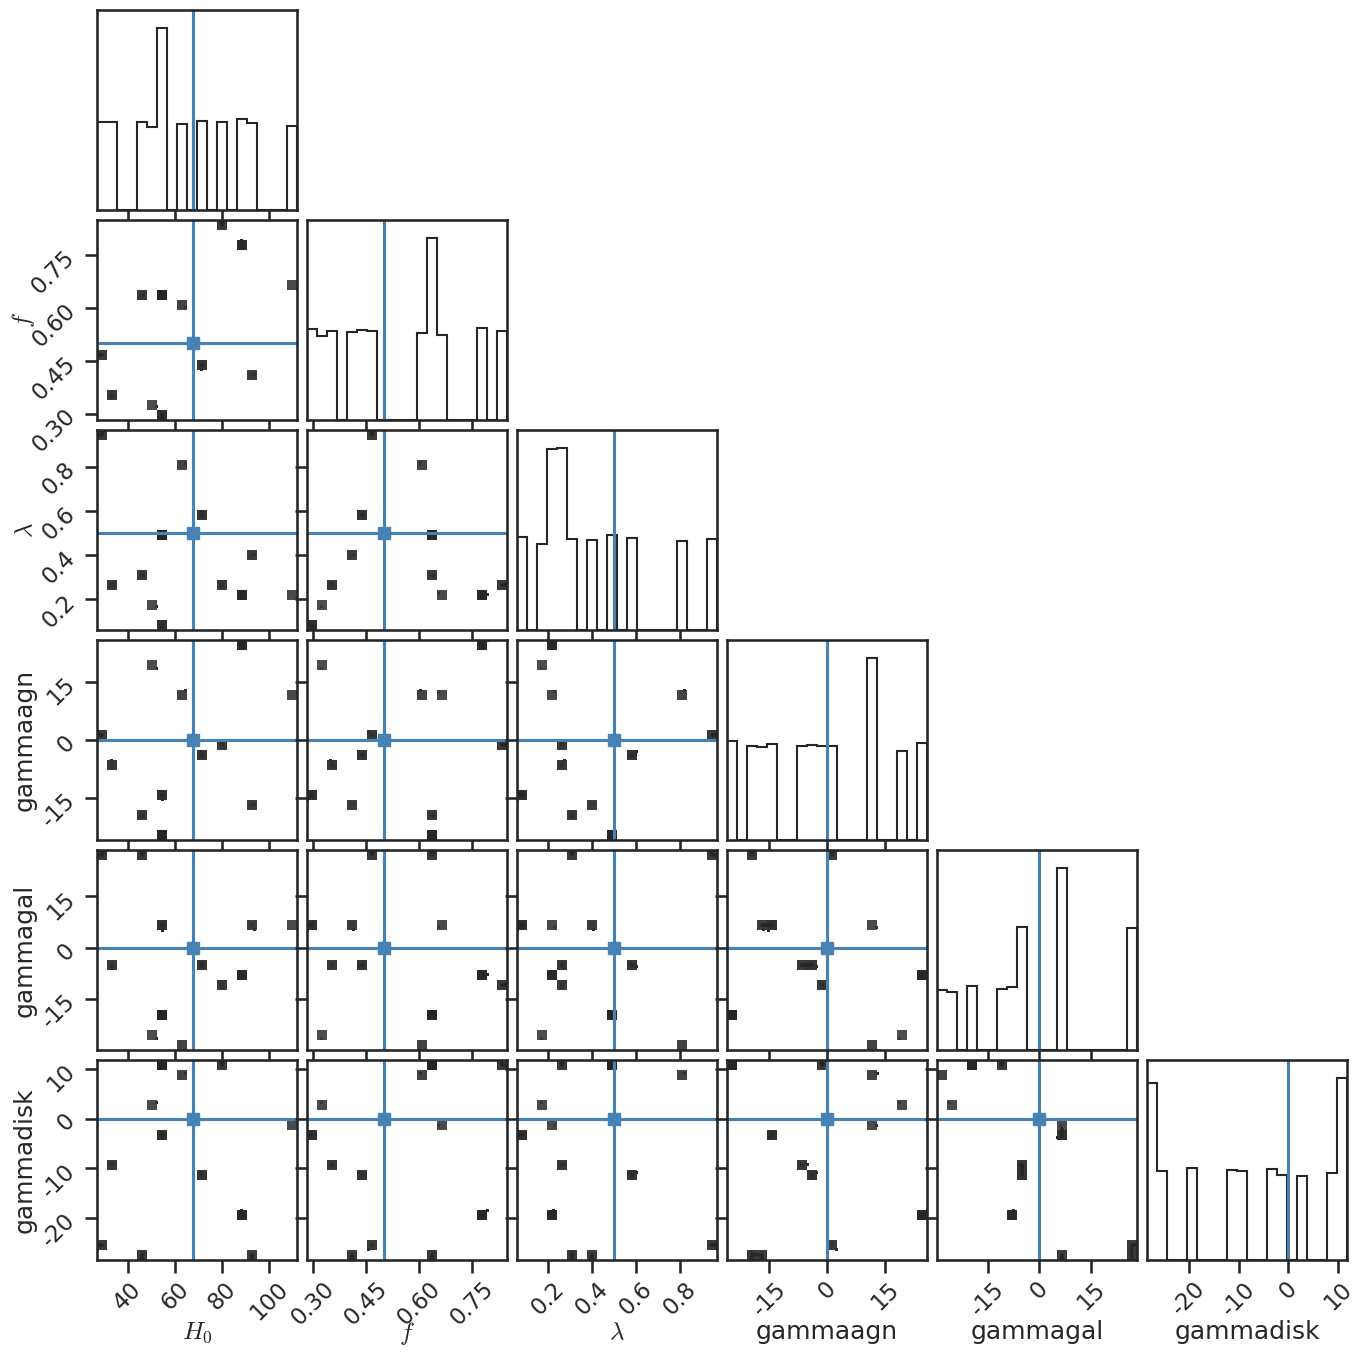

In [18]:
import corner

dpostsamples = dpostsamples_backup[choose]

ranges=[]
for k in range(len(lower_bound)):
    ranges.append((lower_bound[k],upper_bound[k]))
fig = corner.corner(dpostsamples, labels=labels, hist_kwargs={'density': True},truths=truths)
plt.show()

/tmp/ipykernel_2517067/1263212344.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dpostsamples[:,0])
/hildafs/home/magana/tmp_ondemand_hildafs_phy230014p_symlink/magana/.conda/envs/jax/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


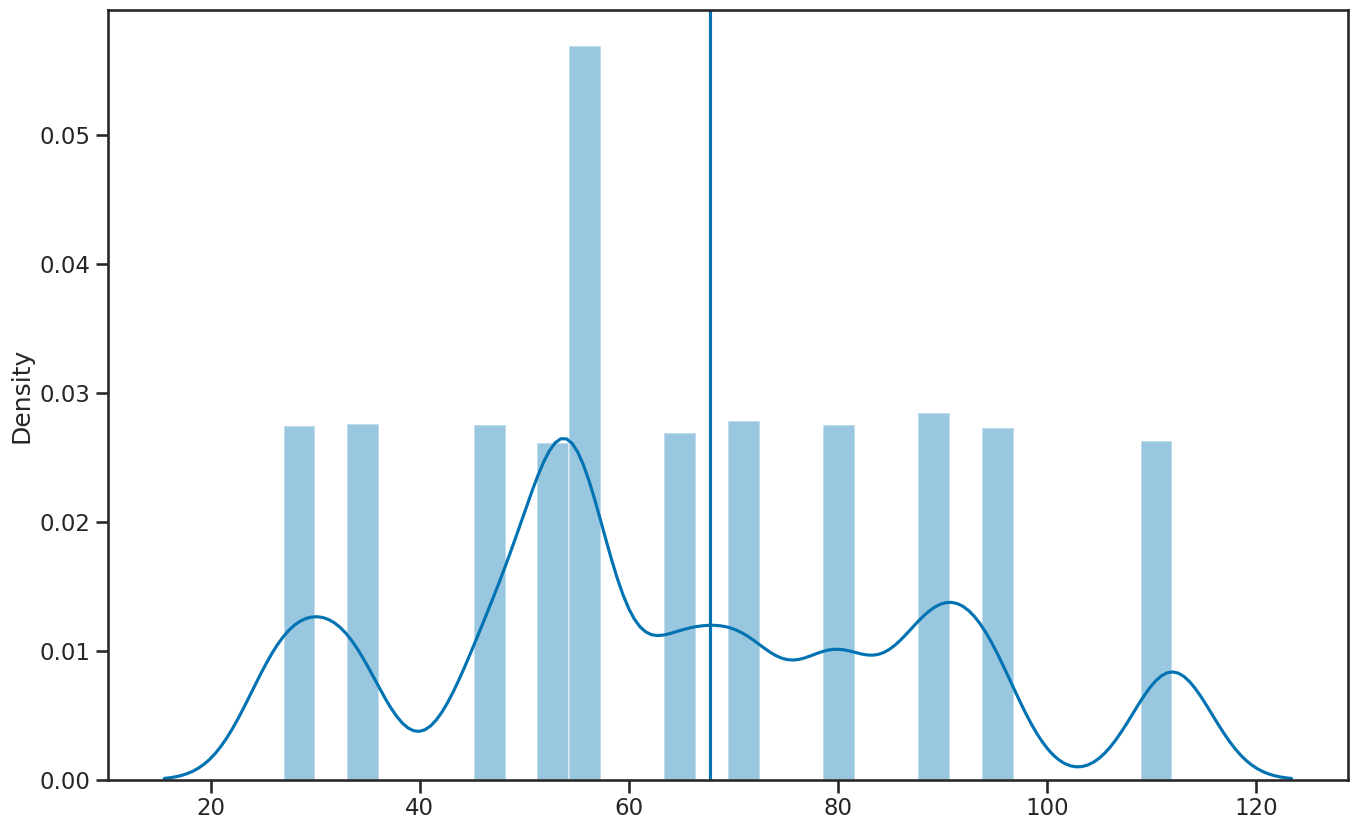

In [19]:
sns.distplot(dpostsamples[:,0])
plt.axvline(H0Planck)
plt.show()